In [1]:
import matplotlib
from matplotlib import pyplot as plt
import scienceplots
from adjustText import adjust_text

## Nature用設定 ##
plt.style.use(['science','nature','sans','no-latex','std-colors'])
plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.figsize'] = (2,2)
# 軸
plt.rcParams['xtick.minor.visible'] = False
plt.rcParams['xtick.major.top'] = False
plt.rcParams['xtick.minor.top'] = False
plt.rcParams['xtick.direction'] = 'out'
plt.rcParams['ytick.minor.visible'] = False
plt.rcParams['ytick.major.right'] = False
plt.rcParams['ytick.minor.right'] = False
plt.rcParams['ytick.direction'] = 'out'
plt.rcParams['axes.spines.right'] = False
plt.rcParams['axes.spines.top'] = False
# 文字
plt.rcParams['xtick.labelsize'] = 5
plt.rcParams['ytick.labelsize'] = 5
plt.rcParams['axes.labelsize'] = 5
plt.rcParams['axes.titlesize'] = 5
plt.rcParams['legend.fontsize'] = 5
# その他
plt.rcParams['axes.grid'] = False


import numpy as np
import pandas as pd
import pickle

# from adjustText import adjust_text
import seaborn as sns

from tqdm import tqdm
from scipy import stats
from scipy.stats import spearmanr,ttest_1samp, pearsonr

import configparser
config = configparser.ConfigParser()
config.read('./config.ini', encoding='utf-8')
SAVE_DIR = config.get('settings','SAVE_DIR')
WORK_DIR = config.get('settings','WORK_DIR')
SHARE_DIR = config.get('settings','SHARE_DIR')

settings = configparser.ConfigParser()
settings.read('./settings.ini', encoding='utf-8')
MIN_YEAR = int(settings.get('experiment','MIN_YEAR'))
MAX_YEAR = int(settings.get('experiment','MAX_YEAR'))
RESOLUTION = float(settings.get('experiment','RESOLUTION'))
NMIN = int(settings.get('experiment','NMIN'))
RESOLUTION_TOPIC = float(settings.get('experiment','RESOLUTION_TOPIC'))
NMIN_TOPIC = int(settings.get('experiment','NMIN_TOPIC'))

# load

In [2]:
papers = pd.read_pickle('/disks/qnap2/data/t-miura/2023_readership/final_paper/papers_2016_all_validread.pickle')
for year in range(2016,2022):
    papers[f'c_history_sum_{year}'] = papers['c_history'].map(lambda l: sum(l[:year-2015]))

papers_hcp = papers[papers['label_hml_2021'].isin(['top'])].copy()
papers_mcp = papers[papers['label_hml_2021'].isin(['middle'])]
papers_lcp = papers[papers['label_hml_2021'].isin(['bottom'])]
papers_slow = papers[(papers['label_hml_2018'].isin(['middle','bottom']))&(papers['label_hml_2021'].isin(['top']))]
papers_fast = papers[(papers['label_hml_2018'].isin(['top']))&(papers['label_hml_2021'].isin(['top']))]
papers_low = papers[(papers['label_hml_2018'].isin(['middle','bottom']))&(papers['label_hml_2021'].isin(['middle','bottom']))]

print('hcp', papers_hcp.shape)
print('mcp', papers_mcp.shape)
print('lcp', papers_lcp.shape)
print('slow', papers_slow.shape)
print('fast', papers_fast.shape)
print('------')

# ジャーナルマッチのみで行う
papers_slow_lowmatched2018_journal = papers.loc[pd.read_pickle('/disks/qnap2/data/t-miura/2023_readership/final_paper/papers_slow_1e-06_lowmatched2018_journal.pickle').index]
papers_low_slowmatched2018_journal = papers.loc[pd.read_pickle('/disks/qnap2/data/t-miura/2023_readership/final_paper/papers_low_1e-06_slowmatched2018_journal.pickle').index]
papers_slow_fastmatched2021_journal = papers.loc[pd.read_pickle('/disks/qnap2/data/t-miura/2023_readership/final_paper/papers_slow_1e-06_fastmatched2021_journal.pickle').index]
papers_fast_slowmatched2021_journal = papers.loc[pd.read_pickle('/disks/qnap2/data/t-miura/2023_readership/final_paper/papers_fast_1e-06_slowmatched2021_journal.pickle').index]

_ = pd.read_excel(
     SAVE_DIR+f'paper_detail/keywords_in_2021_{RESOLUTION}_{NMIN}_tficf_waltman_name.xlsx', 
     sheet_name='names'
 )[['partition','n_1970-2021','n_2016','nameByGPT-4'] + [f'word{i}' for i in range(5)]]
keywords = {int(k):v for k,v in _.set_index('partition')['nameByGPT-4'].to_dict().items()}
print(keywords)

## 各トピックのTF-IDFが最も高い単語
topic_keywords = {k: [v[0],v[1],v[2]]
    for k,v in pd.read_pickle(SAVE_DIR+f'paper_detail/keywords_in_2021_{RESOLUTION_TOPIC}_{NMIN_TOPIC}_tficf_waltman.pickle').items()
}

hcp (248831, 39)
mcp (1057318, 39)
lcp (981937, 39)
slow (54246, 39)
fast (194585, 39)
------
{-1: nan, 0: 'Molecular & Cellular Biology', 1: 'Neuropsychiatric Disorders', 2: 'Organic & Inorganic Chemistry', 3: 'Social & Political Sciences', 4: 'Ecology & Evolution', 5: 'Nutrition & Microbiome', 6: 'Nanomaterials & Energy Storage', 7: 'Computer Vision & Security', 8: 'Cardiovascular Medicine', 9: 'Wireless Networks & Security', 10: 'Biomaterials & Orthopedics', 11: 'Fluid Mechanics & Heat Transfer', 12: 'Astronomy & Astrophysics', 13: 'Environmental Science & Technology', 14: 'Information & Computer Science', 15: 'Materials Science & Engineering', 16: 'Plant Science & Stress Responses', 17: 'Quantum Physics & Superconductivity', 18: 'Geology & Tectonics', 19: 'Climate Science & Remote Sensing', 20: 'Gastroenterology & Surgery', 21: 'Respiratory & Critical Care Medicine', 22: 'Power Systems & Smart Grids', 23: 'Structural Engineering & Materials', 24: 'Metamaterials & Antennas', 25: 'Vi

In [3]:
# MAX_PARTITION = 47 # 論文が10000以上ある分野に絞る
MAX_PARTITION = 65 # 全分野の場合

with open(SAVE_DIR+f'paper_detail/partition_to_ASJC_in_2021_{RESOLUTION}_{NMIN}.pickle','rb') as f:
    pid_to_largefield = pickle.load(f)
    
target_partitions = []
for i in [3,1,0,2]:
    target_partitions.extend([k for k,v in pid_to_largefield.items() if (v == i) & (k < MAX_PARTITION+1) & (k != -1)])
target_partitions_dic = {k:i+1 for i,k in enumerate(target_partitions)}

# read/cited transition

SCP+FCP: [1.3162834498745282, 1.9302131280604717, 1.5753280350067516, 1.6409841253229547, 1.488301377966419, 1.402156233157232]
LCP+FIP: [1.123472209843051, 1.8929171669245708, 2.301728593838206, 2.7932842831813005, 2.8753336358661756, 2.966311896124987]
SCP: [1.3158176046964218, 2.652240710164983, 2.212477067383552, 2.060187640900604, 1.7626620173932928, 1.600498645066116]
FCP: [1.3164133339230752, 1.755695732039765, 1.421406983729288, 1.5347139100229987, 1.4167935635723916, 1.3496103713252405]
all: [1.2037376103856054, 1.9651544995181007, 2.0241469544029527, 2.255496926909253, 2.2199312465800918, 2.204843898460087]


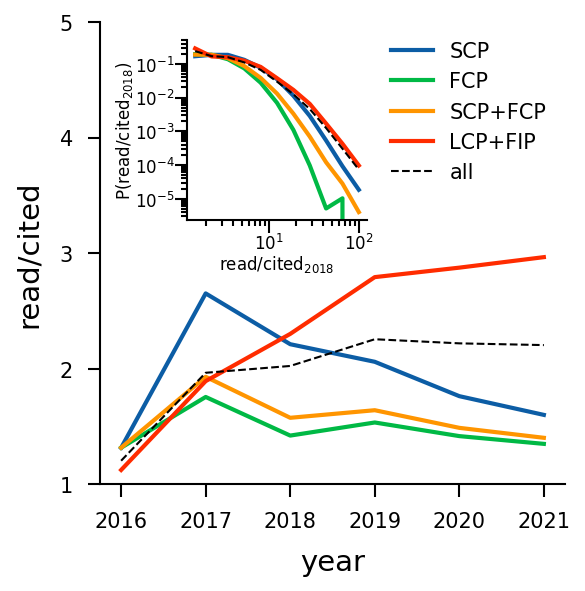

In [8]:
def _log_mean_exp(series):
    return np.exp(series.map(lambda x: np.log(x+1)).mean()) - 1
    

x = range(2016,2022)
y_hcp = [_log_mean_exp(papers_hcp[f'read_percite_{year}']) for year in x] 
y_lcp = [_log_mean_exp(papers_lcp[f'read_percite_{year}']) for year in x] 
y_slow = [_log_mean_exp(papers_slow[f'read_percite_{year}']) for year in x] 
y_fast = [_log_mean_exp(papers_fast[f'read_percite_{year}']) for year in x] 
y_all = [_log_mean_exp(papers[f'read_percite_{year}']) for year in x] 
print(f'SCP+FCP: {y_hcp}')
print(f'LCP+FIP: {y_lcp}')
print(f'SCP: {y_slow}')
print(f'FCP: {y_fast}')
print(f'all: {y_all}')

fig, ax = plt.subplots(figsize=(2,2))
ax.plot(x,y_slow, label='SCP')
ax.plot(x,y_fast, label='FCP')
ax.plot(x,y_hcp, label='SCP+FCP')
ax.plot(x,y_lcp, label='LCP+FIP')
ax.plot(x,y_all, label='all', linewidth=0.5, color='black', linestyle='--')

ax.set_xticks(x)
ax.set_xticklabels(x)
ax.set_yticks([1,2,3,4,5])
ax.set_yticklabels([1,2,3,4,5])
ax.set_xlabel('year',fontsize=7)
# ax.set_yscale('log')
ax.set_ylabel('read/cited',fontsize=7)
ax.set_ylim(1,5)
ax.legend(bbox_to_anchor=(1,1), loc='upper right')

ax2 = fig.add_axes([.27, .55, .3, .3])

df = papers_slow.copy()
df['read_percite_2018_log'] = df['read_percite_2018'].map(lambda x: np.log(x+1))
y, bins = np.histogram(df['read_percite_2018'].values, bins=np.logspace(0,2,12))
ax2.plot(bins[1:], y/len(df), label='SCP')

df = papers_fast.copy()
df['read_percite_2018_log'] = df['read_percite_2018'].map(lambda x: np.log(x+1))
y, bins = np.histogram(df['read_percite_2018'].values, bins=np.logspace(0,2,12))
ax2.plot(bins[1:], y/len(df), label='FCP')

df = papers_hcp.copy()
df['read_percite_2018_log'] = df['read_percite_2018'].map(lambda x: np.log(x+1))
y, bins = np.histogram(df['read_percite_2018'].values, bins=np.logspace(0,2,12))
ax2.plot(bins[1:], y/len(df), label='SCP+FCP')

df = papers_lcp.copy()
df['read_percite_2018_log'] = df['read_percite_2018'].map(lambda x: np.log(x+1))
y, bins = np.histogram(df['read_percite_2018'].values, bins=np.logspace(0,2,12))
ax2.plot(bins[1:], y/len(df), label='LCP+FIP')

df = papers.copy()
df['read_percite_2018_log'] = df['read_percite_2018'].map(lambda x: np.log(x+1))
y, bins = np.histogram(df['read_percite_2018'].values, bins=np.logspace(0,2,12))
ax2.plot(bins[1:], y/len(df), label='all', color='black',linewidth=0.5, linestyle='--')

ax2.set_xscale('log')
ax2.set_yscale('log')
ax2.set_xlabel('read/cited$_{2018}$', fontsize=4, labelpad=0)
ax2.set_ylabel('P(read/cited$_{2018}$)', fontsize=4, labelpad=0)
ax2.tick_params(axis='both', labelsize=4, pad=0)

ax.legend()
plt.savefig('./read_percite_chronological.eps')
plt.show()

# read dominant SCP, apply dominant SCP

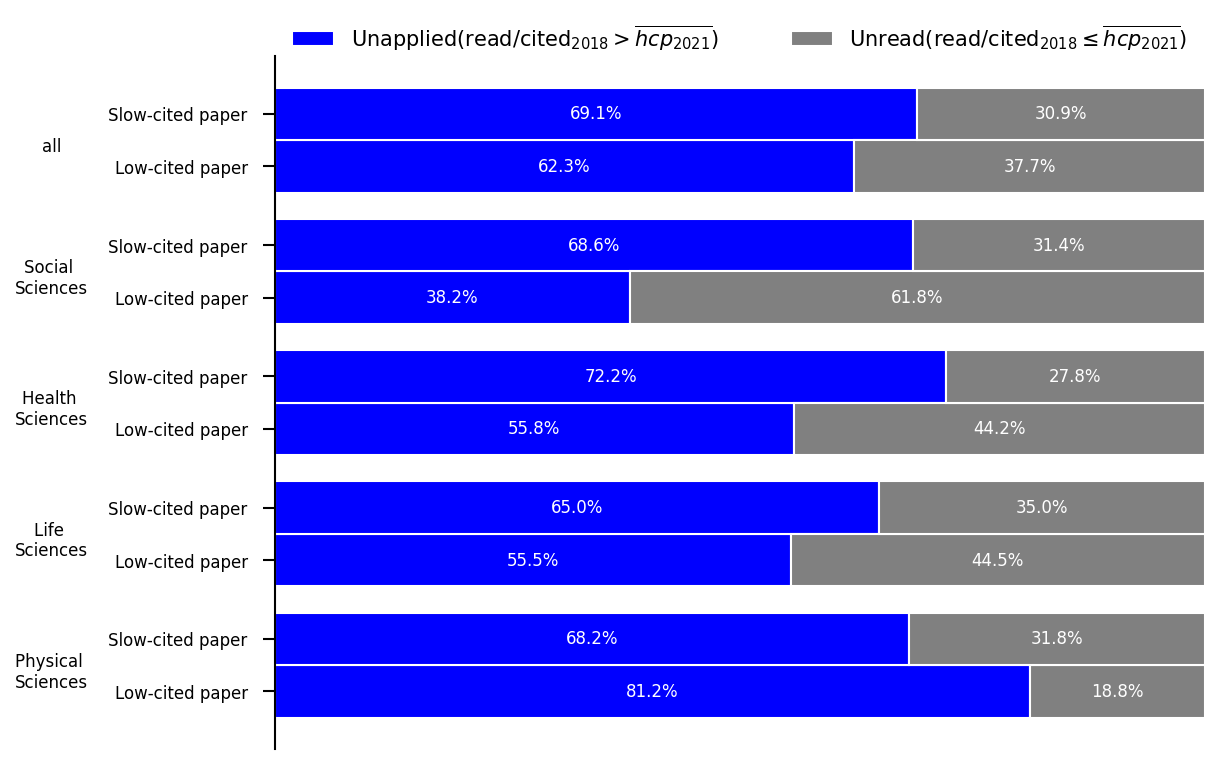

In [7]:
## 作図

plt.rcParams['axes.spines.bottom'] = False
plt.rcParams['xtick.major.bottom'] = False
plt.rcParams['xtick.minor.bottom'] = False

# l = ['Physical Science', 'Life Science', 'Health Science', 'Social Science','all']
x = np.array([0.812, 0.682, 0.555, 0.650, 0.558, 0.722, 0.382, 0.686, 0.623, 0.691])*100 #各分野のbottom, middleの平均とSCPの平均を列挙したもの

fig,ax = plt.subplots(figsize=(4,3))
y = [0, 0.4, 1, 1.4, 2, 2.4, 3, 3.4, 4, 4.4]
left_data = np.zeros(10)

bar_list = ax.barh(y, x  , left=left_data, edgecolor="white", linewidth=0.5, height=0.4)
for i, _ in enumerate(bar_list):
        _.set_facecolor('blue')
for xx, yy in zip(x,y):
    plt.text(xx/2,yy, f'{xx:.1f}%', fontsize=4, color='white', horizontalalignment='center',verticalalignment='center')

bar_list = ax.barh(y, [100-xx for xx in x] , left=x, edgecolor="white", linewidth=0.5, height=0.4)
for _ in bar_list:
    _.set_facecolor('gray')
for x_base, xx, yy in zip(x, [100-xx for xx in x],y):
    plt.text(x_base + xx/2 ,yy, f'{xx:.1f}%', fontsize=4, color='white', horizontalalignment='center',verticalalignment='center',)

plt.text(-24, 0.15, 'Physical \nSciences', horizontalalignment='center',verticalalignment='center', fontsize=4)
plt.text(-24, 1.15, 'Life \nSciences', horizontalalignment='center',verticalalignment='center', fontsize=4)
plt.text(-24, 2.15, 'Health \nSciences', horizontalalignment='center',verticalalignment='center', fontsize=4)
plt.text(-24, 3.15, 'Social \nSciences', horizontalalignment='center',verticalalignment='center', fontsize=4)
plt.text(-24, 4.15, 'all', horizontalalignment='center',verticalalignment='center', fontsize=4)
    
# ax.legend(['read/cited$_{2018}$$>$hcp$_{2021}$','read/cited$_{2018}$$\leq$hcp$_{2021}$'], loc="upper center", ncol=5, bbox_to_anchor=(0.5, 1), frameon=False, borderaxespad=-2, columnspacing=3.5)
ax.legend([r'Unapplied(read/cited$_{2018}$$>\overline{hcp_{2021}}$)',r'Unread(read/cited$_{2018}$$\leq\overline{hcp_{2021}}$)'], loc="upper center", ncol=5, bbox_to_anchor=(0.5, 1), frameon=False, borderaxespad=-2, columnspacing=3.5)
ax.set_xlim([0,100])
ax.set_yticks(y)
ax.set_yticklabels(['Low-cited paper', 'Slow-cited paper']*5, fontsize=4)

plt.savefig('./read_dominat_SCP_rate.eps')
plt.show()

plt.rcParams['axes.spines.bottom'] = True
plt.rcParams['xtick.major.bottom'] = True
plt.rcParams['xtick.minor.bottom'] = True

# mapping

In [7]:
all_papers = pd.concat([
    pd.read_pickle('/disks/qnap2/data/t-miura/2023_readership/paper_detail/partition_in_2021_0.0005_1000_waltman.pickle'),
    pd.read_pickle('/disks/qnap2/shared/scopus_2022/paper_detail/year.pickle'),
],axis=1).dropna(subset=['partition_0.0005'])

topic_mean_year = all_papers.groupby('partition_0.0005')['year'].mean() #トピックの平均年齢
topic_rate_over2019 = all_papers.groupby('partition_0.0005')['year'].agg(lambda x: (x >= 2019).sum()/len(x)) #トピックの2019以降の論文数
topic_read_percite2018 = papers.groupby('partition_0.0005')['read_percite_2018'].agg(lambda x: np.exp(np.log(x).mean())) # 2018のread/citedのlogarithmic mean

In [8]:
# slowが10本以上あるトピックに絞る
_ = papers_slow.value_counts('partition_0.0005')
topic_large = _[_>10].index

# asjcへの割り振り, -1になっているものはASJCの割り振りがない
colors = np.array(plt.rcParams['axes.prop_cycle'].by_key()['color'])[[0,1,2,3]]
with open(SAVE_DIR+f'paper_detail/partition_to_ASJC_in_2021_0.0005_1000.pickle','rb') as f:
    pid_to_largefield = pickle.load(f)
asjc_valid_topics = set([k for k,v in pid_to_largefield.items() if v != -1])

asjc_name = {
    0: 'Health Sciences',
    1: 'Life Sciences',
    2: 'Physical Sciences',
    3: 'Social Sciences'
}

1159
0.021666968627483324
r,p= PearsonRResult(statistic=0.10264975743779958, pvalue=0.09927926801699523)
0 [ 1.11237159 17.13522644]
r,p= PearsonRResult(statistic=-0.055299318481543985, pvalue=0.4510016532825338)
1 [-0.82172457 22.0032769 ]
r,p= PearsonRResult(statistic=0.16301391405783344, pvalue=0.000393190289054496)
2 [ 4.0827655  20.40305809]
r,p= PearsonRResult(statistic=0.32482118032142315, pvalue=2.2373323070372254e-07)
3 [ 3.02111786 13.79208214]


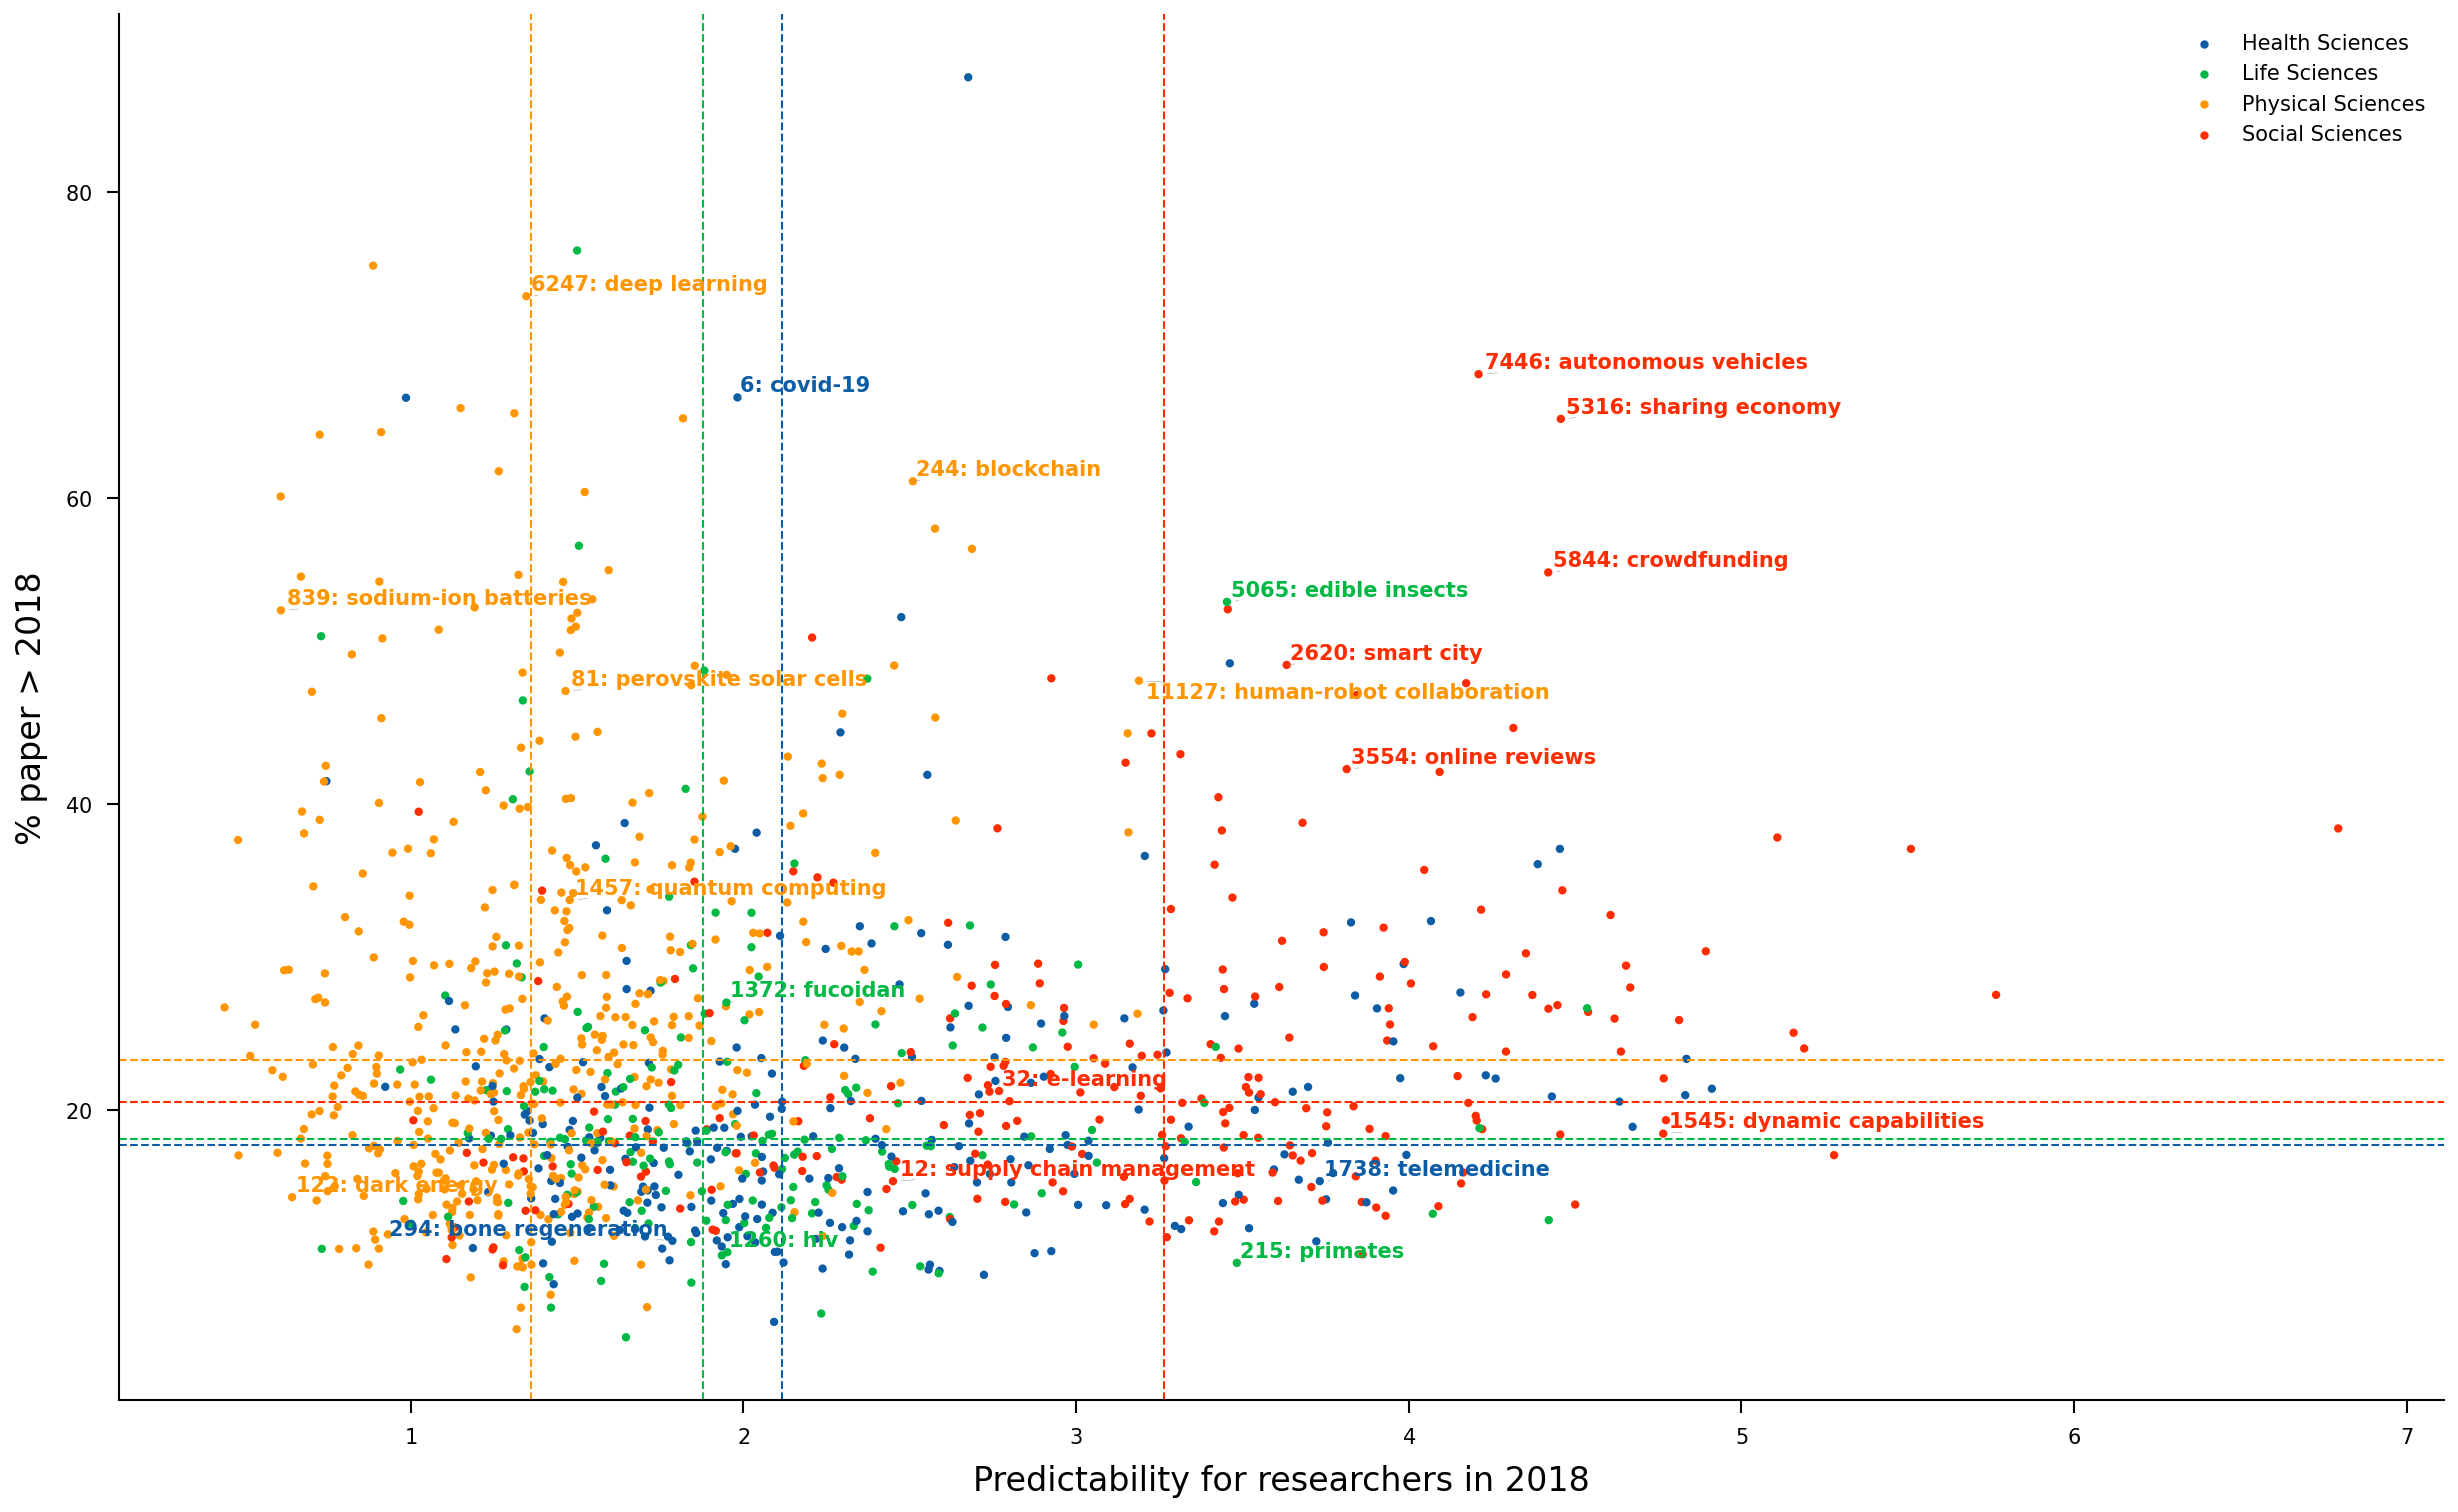

In [51]:
idxs = list(set(topic_read_percite2018.index) & set(topic_rate_over2019.index) & set(topic_large) & set(asjc_valid_topics) - set([-1])) #十分に大きくて、validなデータ
print(len(idxs))
topic_display = [
    # Health Science
    6, #covid-19
    1738, #telemedicine
    294, #bone regeneration
    # Life Science
    5065, #edible insects
    1260, #hiv
    215, #primates
    1372, #fucoidan
    # Physical Sciences
    11127, #human-robot collaborations
    244, #blockchain
    6247, #deep learning
    81, #perovskite solar celss
    1457, #quantum computing
    122, #dark energy
    839, #sodium-ion batteries
    # Social Sciences
    32, #e-learning
    7446, #autonomous vehicles
    5316, #sharing economy
    5844, #crowdfunding
    # 3205, #circular economy
    3554, #online reviews
    2620, #smart city
    1545, #dynamic capabilities
    12, #supply chain management
    
]

x = topic_read_percite2018.loc[idxs].values
y = topic_rate_over2019.loc[idxs].values * 100
print(np.corrcoef(x,y)[0][1])

scatter_colors = [colors[pid_to_largefield[idx]] for idx in idxs]

fig,ax = plt.subplots(figsize=(10,6))
ax.scatter(x,y,s=1,c=scatter_colors) ##TODO## 色をpid_to_largefieldに合わせて変える

# 各分野の相関係数, 近似直線
for i in range(4):
    x_field = [xx for xx,topic in zip(x,idxs) if pid_to_largefield[topic] == i]
    y_field = [yy for yy,topic in zip(y,idxs) if pid_to_largefield[topic] == i]
    x_fit = [min(x_field),max(x_field)]
    print('r,p=',pearsonr(x_field,y_field))
    coef = np.polyfit(x_field,y_field,1)
    y_fit = np.poly1d(coef)(x_fit)
    # ax.plot(x_fit,y_fit,color=colors[i],linewidth=1)
    print(i, coef)

##TODO## 中央値 or 平均値で区切って、予測不能な発見と、予測不可能な発見に分ける
# ax.axvline(np.median(x), linestyle='--',c='black', linewidth=0.5)
# ax.axhline(np.median(y), linestyle='--',c='black', linewidth=0.5)
for i in range(4):
    x_field = [xx for xx,topic in zip(x,idxs) if pid_to_largefield[topic] == i]
    y_field = [yy for yy,topic in zip(y,idxs) if pid_to_largefield[topic] == i]
    ax.axvline(np.median(x_field), linestyle='--',c=colors[i], linewidth=0.5)
    ax.axhline(np.median(y_field), linestyle='--',c=colors[i], linewidth=0.5)

##TODO## 代表的な単語にアノテーションをつける
# ax.set_xlabel('read/cited$_{2018}$ of paper$_{2016}$')
# ax.set_ylabel('% paper > 2018')
ax.set_xlabel('Predictability for researchers in 2018', fontsize=8)
ax.set_ylabel('% paper > 2018',fontsize=8)

for k,name in asjc_name.items():
    ax.scatter([],[],s=1,c=colors[k],label=name)

ax.legend()

texts = [
    ax.text(xx, yy, f'{int(topic_id)}: ' + topic_keywords[topic_id][0], ha='center', va='center',fontsize=5, weight='bold', color=colors[pid_to_largefield[topic_id]]) 
    for xx,yy,topic_id in zip(x,y,idxs) 
    if topic_id in topic_display
    # if (yy < 0.15) & (yy > 0) & (xx < 2)
]
adjust_text(texts,force_text=(0.1,0.3),arrowprops=dict(arrowstyle='-', color='gray',linewidth=0.1))

# plt.savefig('./read_percite_topicmap_display.pdf')

plt.show()

In [39]:
_ = pd.DataFrame(topic_keywords).T.sort_index()
_['field'] = _.index.map(pid_to_largefield)
_['x'] = topic_read_percite2018.reindex(_.index)
_['y'] = topic_rate_over2019.reindex(_.index)
display(_)
# _[_.index.isin(idxs)].sort_values('field').to_csv('./topics_display.csv')

,0,1,2,field,x,y
-1,new species,poetry,cultivar,3,1.148692,0.094996
0,density functional theory,dft,method mndo,2,1.318333,0.057011
1,technology acceptance model,e-commerce,trust,3,2.735115,0.216460
2,adsorption,biosorption,activated carbon,2,1.215543,0.174690
3,innovation,open innovation,absorptive capacity,3,2.220505,0.170108
...,...,...,...,...,...,...
15515,privacy protection,privacy,video surveillance,2,1.909011,0.291000
15516,random walk in random environment,random environment,random walk,3,0.703321,0.144000
15517,disability,poverty,persons with disabilities,3,2.916720,0.237000
15518,pim-1,pim1,pim kinase,1,1.401359,0.205000
